# Stock price forecasting system
Authors: Leonardo Emili, Alessio Luciani

## Project setup

In [24]:
try:
    # Setup the project directory if running on Colab
    from google.colab import drive
    drive.mount('/content/gdrive/')
    !cp gdrive/MyDrive/stock-forecasting-proj/data.zip .
    !unzip -q data.zip
    !rm data.zip
except:
    pass

In [25]:
%matplotlib inline

# Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import missingno as msno

# Torch
import torch
import torch.nn as nn

# General
import glob
from tqdm.notebook import tqdm
from typing import *
import datetime

## Dataset loading

In [26]:
# Key stats dataframe
key_stats_df = pd.read_csv("data/key_stats_yahoo.csv")
key_stats_df.drop(key_stats_df.columns[0], axis=1, inplace=True)
key_stats_df.Date = pd.to_datetime(key_stats_df.Date)

# Prices dataframes for every stock
prices_files = glob.glob("data/prices/*.csv")
dfs_names = [f.rsplit('/', 1)[1][:-len('.csv')] for f in prices_files]
prices_dfs = []
for f in tqdm(prices_files, desc='Reading stock price data', total=len(prices_files)):
    df = pd.read_csv(f)
    df.Date = pd.to_datetime(df.Date)
    prices_dfs.append(df)

Reading stock price data:   0%|          | 0/429 [00:00<?, ?it/s]

## Dataset analysis

In [27]:
print("Key stats dataframe format:")
key_stats_df.head()

Key stats dataframe format:


,Date,Ticker,Price,DE Ratio,Trailing P/E,Price/Sales,Price/Book,Profit Margin,Operating Margin,Return on Assets,...,Diluted EPS,Earnings Growth,Revenue Growth,Total Cash,Total Cash Per Share,Total Debt,Current Ratio,Book Value Per Share,Cash Flow,Beta
0,2004-01-30 19:01:00,a,33.8320,0.407,NaN,2.80,6.01,29.56,11.97,24.95,...,3.774,NaN,0.8,1.610000e+09,3.370,1.150000e+09,2.040,5.930,144000000.0,2.474
1,2004-04-13 04:07:00,a,28.4626,0.375,NaN,2.43,4.98,25.56,6.20,23.59,...,3.391,NaN,0.8,1.680000e+09,3.490,1.150000e+09,2.284,6.394,144000000.0,2.496
2,2004-12-13 21:37:00,a,21.8816,0.323,33.58,1.61,3.24,4.86,5.38,5.26,...,0.710,NaN,0.8,2.320000e+09,4.750,1.150000e+09,2.441,7.320,483000000.0,2.547
3,2005-01-22 05:17:00,a,20.2478,0.322,30.70,1.52,3.04,4.86,5.38,5.26,...,0.710,NaN,18.6,2.320000e+09,4.710,1.150000e+09,2.446,7.329,663000000.0,2.166
4,2006-01-09 02:35:00,a,31.7118,2.169,52.82,3.31,4.26,6.38,3.58,1.68,...,0.660,64.9,22.8,2.250000e+09,4.555,2.169000e+00,2.169,8.095,890000000.0,NaN


In [28]:
print("Prices dataframe format:")
prices_dfs[0].head()

Prices dataframe format:


,Date,Low,Open,Volume,High,Close,Adjusted Close
0,1990-02-16,0.073785,0.0,940636800,0.079861,0.077257,0.057364
1,1990-02-20,0.074653,0.0,151862400,0.079861,0.079861,0.059297
2,1990-02-21,0.075521,0.0,70531200,0.078993,0.078125,0.058008
3,1990-02-22,0.078993,0.0,45216000,0.081597,0.078993,0.058653
4,1990-02-23,0.078125,0.0,44697600,0.079861,0.078559,0.058331


### Utility functions

In [29]:
def prices_df_nan_summary(prices_dfs, names):
    ''' Utility function to summarize columns that have missing values. '''
    nan_dfs = []
    for i, (prices_df, name) in enumerate(zip(prices_dfs, names)):
        nan_cols = []
        nan_values = []
        for column in prices_df.columns:
            nan_absolute = prices_df[column].isnull().sum()
            if nan_absolute > 0:
                # Only consider columns that cointain NaN values
                nan_cols.append(column)
                nan_values.append(nan_absolute)
        if len(nan_cols):
            # Either we have all the data for a given day or we don't have any data for it
            assert len(set(nan_values)) == 1
            count = nan_values[0]
            nan_dfs.append((name, round(100*count/len(prices_df.index), 3), count))
    return pd.DataFrame(nan_dfs, columns=['Stock name', 'Missing data (%)', 'Count'])

def remove_trailing_nan(df: pd.DataFrame, ticker: str, col: str = 'Low') -> pd.DataFrame:
    '''
    A trick to detect if the input DataFrame ends with a contiguous collection of NaN rows.
    It is mainly an adaptation from: https://stackoverflow.com/questions/29007830/identifying-consecutive-nans-with-pandas
    '''
    if ticker == 'CTQ':
        # This special case refers to a stock that is not active for a long period but contains two days of activity:
        # up ..... up down ..... down [up down ... down up] down ..... down
        # We consider the period comprised in square brackets as an inactivity period. Otherwise feature imputation
        # would be harder and less reliable, hence dropping a few rows (i.e. 2) increases the quality of our data.
        df.iloc[1397] = np.nan
        df.iloc[1400] = np.nan
    group_by_nan = df[col].isnull().astype(int).groupby(df[col].notnull().astype(int).cumsum()).cumsum()
    training_nans = group_by_nan.iloc[-1]
    return df[:-training_nans] if training_nans > 0 else df

def merge_prices_fundamentals(
    prices_dfs: List[pd.DataFrame],
    key_stats_df: pd.DataFrame,
    dfs_names: List[str],
    drop_cols: List[str] = ['Date', 'Ticker', 'Price']
    ) -> List[pd.DataFrame]:

    # Define the target list of dataframes
    prices_dfs_new = []
    for ticker, ticker_df in tqdm(key_stats_df.groupby('Ticker'), desc='Merging the datasets ...'):
        # Consider only stocks for which we have fundamental data
        if ticker.upper() not in dfs_names: continue
        
        # The current financial report
        ticker_iterator = list(ticker_df.iterrows())
        ticker_iter_idx = 0

        # Merge the two dataset according to the value of ticker_date
        ticker_row = ticker_iterator[ticker_iter_idx][1]
        ticker_date = ticker_row.Date
        ticker_row.drop(drop_cols, inplace=True)
        fundamental_cols, financial_values = ticker_row.index, ticker_row.values

        # Consider the relative stock ticker dataframe
        prices_df_idx = dfs_names.index(ticker.upper())
        prices_df = prices_dfs[prices_df_idx]
        # Dropping unused price value columns (we are using adjusted close)
        prices_df = prices_df.drop(['High', 'Low', 'Open', 'Close'], axis=1)
        fundamental_rows = []

        # Discard events that occurred before the first financial report
        begin_idx = prices_df[prices_df.Date >= ticker_date].index[0]
        for i, row in prices_df[begin_idx:].iterrows():
            # Use the last updated financial report if available (otherwise fast-forward the latest)
            if ticker_date < row.Date and ticker_iter_idx + 1 < len(ticker_iterator):
                # Update info about fundamental data
                ticker_iter_idx += 1
                ticker_row = ticker_iterator[ticker_iter_idx][1]
                ticker_date = ticker_row.Date
                ticker_row.drop(drop_cols, inplace=True)
                financial_values = ticker_row.values
            
            fundamental_rows.append(financial_values)

        # Finally merge the two datasets into one that has the same rows and the union of columns
        fundamental_df = pd.DataFrame(fundamental_rows, columns=fundamental_cols)
        valid_prices_df = prices_df[begin_idx:].reset_index(drop=True)
        merged_df = pd.concat((fundamental_df, valid_prices_df), axis=1)

        assert merged_df.shape == (fundamental_df.shape[0], fundamental_df.shape[1] + valid_prices_df.shape[1])
        prices_dfs_new.append(merged_df)
    
    return prices_dfs_new

def fill_missing_days(aggregate_dfs: List[pd.DataFrame], remove_weekends: bool = True, end_year: int = 2013) -> List[pd.DataFrame]:
    '''
    Returns the aggregated dataframes where gaps have been filled using fast-forward techniques.
    If remove_weekends is specified, only prices for weekdays are retained.
    '''

    def is_weekday(date: datetime) -> bool:
        ''' Returns true if the provided date corresponds to a weekday. '''
        return date.weekday() < 5

    result_dfs = []
    for df in tqdm(aggregate_dfs, desc='Filling missing days ...'):
        rows = list(df.iterrows())
        _, last_row = rows[0]
        
        # Skip datasets (less than 2%) whose available data starts after the end_year
        if end_year is not None and last_row.Date.year > end_year: continue
        date_idx = last_row.index.tolist().index("Date")

        output_rows = [last_row.values.tolist()]
        for _, row in rows[1:]:
            # Skip rows that exceed the end_year
            if end_year is not None and row.Date.year > end_year: break

            # Compute the current time gap in our dataset
            missing_days = (row.Date - last_row.Date).days - 1
            for day_offset in range(1, missing_days+1):
                # Fill the gap adding [day_offset] days with the last observed values
                delta = datetime.timedelta(days=day_offset)
                output_rows.append(last_row.values.tolist())
                output_rows[-1][date_idx] = last_row.Date + delta

            # Add and update the latest observed values
            output_rows.append(row.values.tolist())
            last_row = row
    
        # Skip weekends
        if remove_weekends:
            output_rows = [row for row in output_rows if is_weekday(row[date_idx])]
        result_dfs.append(pd.DataFrame(output_rows, columns=aggregate_dfs[0].columns))
    return result_dfs

### Missing values imputation

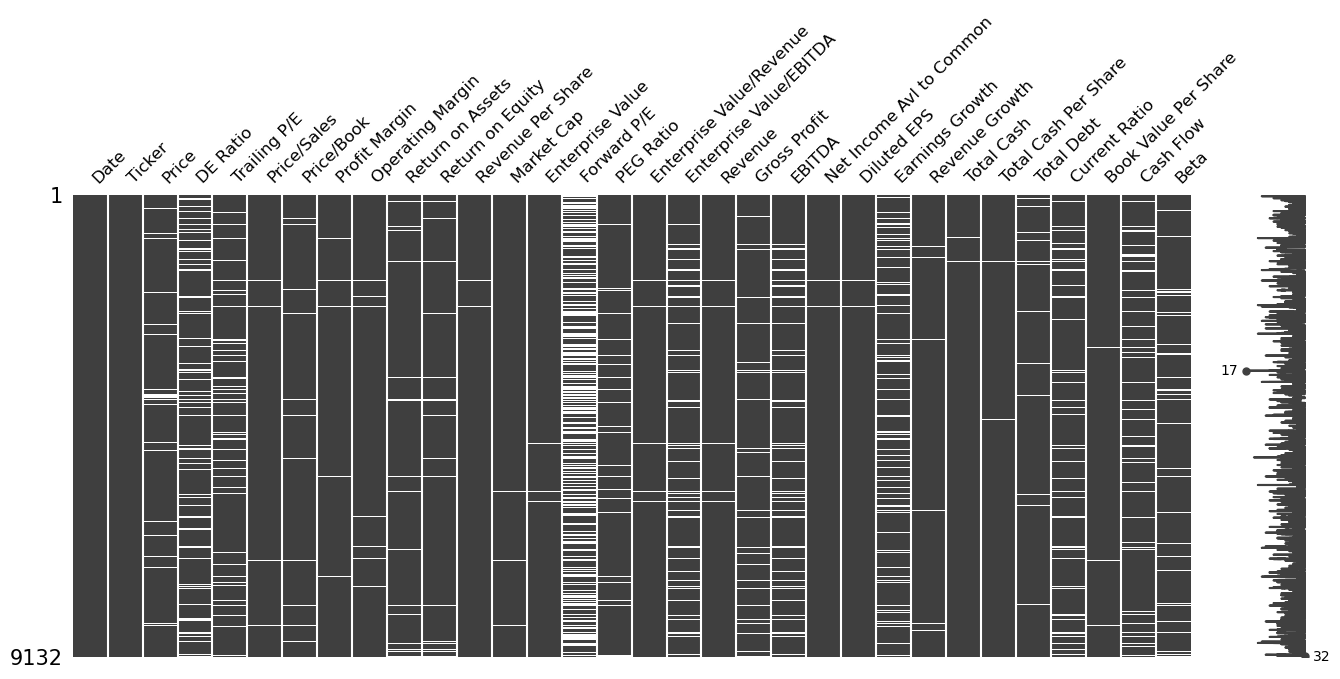

In [30]:
_ = msno.matrix(key_stats_df, figsize=(16,6), fontsize=12)

In [31]:
print("Overview of the missing values in the key_stats dataframe\n")
key_stats_summary = key_stats_df.isna().sum()           \
                        .sort_values(ascending=False)   \
                        .apply(lambda x: f"{round(100*x/len(key_stats_df.index), 3)}%")
key_stats_summary

Overview of the missing values in the key_stats dataframe



Forward P/E                  41.251%
DE Ratio                     16.886%
Earnings Growth              15.966%
Enterprise Value/EBITDA      10.633%
EBITDA                        10.37%
Current Ratio                 10.37%
Cash Flow                     9.801%
Trailing P/E                  8.432%
Beta                          4.413%
PEG Ratio                     4.325%
Gross Profit                   3.92%
Total Debt                    3.844%
Price                         3.657%
Return on Equity              3.011%
Return on Assets              2.508%
Price/Book                    2.354%
Revenue Growth                2.146%
Operating Margin              1.391%
Enterprise Value/Revenue      0.942%
Revenue                       0.909%
Total Cash                    0.854%
Enterprise Value              0.723%
Total Cash Per Share          0.712%
Profit Margin                 0.712%
Price/Sales                   0.548%
Book Value Per Share          0.449%
Diluted EPS                   0.296%
M

In [32]:
summary = prices_df_nan_summary(prices_dfs, dfs_names)
px.bar(summary, x='Stock name', y='Missing data (%)', hover_data=['Count'], title="Stock price dataset before preprocessing (only columns with missing values are displayed)")

For most of the above stocks with missing values, we noticed that they indeed exist up to a given time and after that no more data is available. It may due to a business failure, hence no more stocks will be exchanged from that moment on.

In [33]:
# Clear our input data from training NaN values
prices_dfs_new = [remove_trailing_nan(df,name) for df,name in zip(prices_dfs, dfs_names)]

# Remove INTH stock from our dataset since it contains many inactivity periods
inth_idx = dfs_names.index('INTH')
del dfs_names[inth_idx]
del prices_dfs_new[inth_idx]

summary = prices_df_nan_summary(prices_dfs_new, dfs_names)
px.bar(summary, x='Stock name', y='Missing data (%)', hover_data=['Count'], title="Stock price dataset after preprocessing (only columns with missing values are displayed)")

At this point we use the fast forward imputation technique to fill-in missing values. Please note that in this case missing values are mostly due to holidays or periods when stocks are not exchanged.

### Building our new dataset

In [34]:
# Impute missing values in the prices dataset (i.e. fast-forward last valid values)
prices_dfs_new = [df.fillna(method='ffill') for df in prices_dfs_new]
assert pd.concat(prices_dfs_new).isnull().sum().sum() == 0

# In this case this dataframe contains financial reports that may contain NaN values either because that
# metric was not available at that time OR because it was monitoring an initial stage of a company growth.
# What we do is to apply the classic fast-forward, and fill initial missing values with zeroes.
# Please note: we also discard the 'Forward P/E' column since the imputation here would introduce too much noise.
key_stats_df_new = key_stats_df.drop('Forward P/E', axis=1).fillna(method='ffill').fillna(0.)
assert key_stats_df_new.isnull().sum().sum() == 0

# Before merging the two datasets we need to sort them
prices_dfs_new = [df.sort_values(by=['Date']).reset_index(drop=True) for df in prices_dfs_new]
key_stats_df_new = key_stats_df_new.sort_values(by=['Date']).reset_index(drop=True)

# Merge the stock price dataset with fundamental data of the relative company
aggregate_dfs = merge_prices_fundamentals(prices_dfs_new, key_stats_df_new, dfs_names)
assert pd.concat(aggregate_dfs).isnull().sum().sum() == 0

# Fill gaps from the original dataset
filled_dfs = fill_missing_days(aggregate_dfs)
assert pd.concat(filled_dfs).isnull().sum().sum() == 0

Merging the datasets ...:   0%|          | 0/534 [00:00<?, ?it/s]

Filling missing days ...:   0%|          | 0/270 [00:00<?, ?it/s]

In [35]:
dfs = filled_dfs


### Computing technical indicators

In [63]:
def add_sma(dfs, period=10):
    ''' Computes the Simple Moving Average from a given dataframe. '''
    for i in range(len(dfs)):
        ret = np.cumsum(dfs[i]["Adjusted Close"]).to_numpy()
        ret[period:] = ret[period:] - ret[:-period]
        sma = ret[period - 1:] / period
        missing_values = dfs[i].shape[0] - sma.shape[0]
        half_missing_values = missing_values//2
        sma_points = np.empty(dfs[i].shape[0], dtype=float)
        sma_points[half_missing_values:(half_missing_values)+sma.shape[0]] = sma
        sma_points[:half_missing_values] = dfs[i]["Adjusted Close"][:half_missing_values]
        sma_points[half_missing_values+sma.shape[0]:] = dfs[i]["Adjusted Close"][half_missing_values+sma.shape[0]:]
        dfs[i]["SMA"] = sma_points

"""
def add_rsi(prices, period=14):
    ''' Computes the Relative Strength Index from a given NumPy array. 
        Formula available at https://en.wikipedia.org/wiki/Relative_strength_index.
        Also adds overbought and oversold when the RSI index hits 70 or 30.'''
    smmau = 0
    smmad = 0
    prices[0,4] = 50
    for i in range(1, prices.shape[0]):
        u = max(0, prices[i,2] - prices[i-1,2])
        d = max(0, prices[i-1,2] - prices[i,2])
        smmau = (smmau * (period - 1) + u) / period
        smmad = (smmad * (period - 1) + d) / period
        if smmad == 0 or smmau == 0:
            prices[i,4] = 50
        else:    
            rs = smmau / smmad
            rsi = 100 - (100/(1+rs))
            prices[i,4] = rsi
            if rsi >= 70: prices[i,7] = 1
            if rsi <= 30: prices[i,8] = 1"""


"\ndef add_rsi(prices, period=14):\n    ''' Computes the Relative Strength Index from a given NumPy array. \n        Formula available at https://en.wikipedia.org/wiki/Relative_strength_index.\n        Also adds overbought and oversold when the RSI index hits 70 or 30.'''\n    smmau = 0\n    smmad = 0\n    prices[0,4] = 50\n    for i in range(1, prices.shape[0]):\n        u = max(0, prices[i,2] - prices[i-1,2])\n        d = max(0, prices[i-1,2] - prices[i,2])\n        smmau = (smmau * (period - 1) + u) / period\n        smmad = (smmad * (period - 1) + d) / period\n        if smmad == 0 or smmau == 0:\n            prices[i,4] = 50\n        else:    \n            rs = smmau / smmad\n            rsi = 100 - (100/(1+rs))\n            prices[i,4] = rsi\n            if rsi >= 70: prices[i,7] = 1\n            if rsi <= 30: prices[i,8] = 1"

In [64]:
add_sma(dfs)

In [66]:
dfs[0]

,DE Ratio,Trailing P/E,Price/Sales,Price/Book,Profit Margin,Operating Margin,Return on Assets,Return on Equity,Revenue Per Share,Market Cap,...,Total Cash Per Share,Total Debt,Current Ratio,Book Value Per Share,Cash Flow,Beta,Date,Volume,Adjusted Close,SMA
0,0.375,0.00,2.43,4.98,25.56,6.20,23.59,46.82,13.16,1.532000e+10,...,3.49,1.150000e+09,2.284,6.394,1.440000e+08,2.496,2004-02-02,4275200,22.490707,22.490707
1,0.375,0.00,2.43,4.98,25.56,6.20,23.59,46.82,13.16,1.532000e+10,...,3.49,1.150000e+09,2.284,6.394,1.440000e+08,2.496,2004-02-03,2838700,21.138302,21.138302
2,0.375,0.00,2.43,4.98,25.56,6.20,23.59,46.82,13.16,1.532000e+10,...,3.49,1.150000e+09,2.284,6.394,1.440000e+08,2.496,2004-02-04,4838400,19.958809,19.958809
3,0.375,0.00,2.43,4.98,25.56,6.20,23.59,46.82,13.16,1.532000e+10,...,3.49,1.150000e+09,2.284,6.394,1.440000e+08,2.496,2004-02-05,4838400,19.958809,19.958809
4,0.375,0.00,2.43,4.98,25.56,6.20,23.59,46.82,13.16,1.532000e+10,...,3.49,1.150000e+09,2.284,6.394,1.440000e+08,2.496,2004-02-06,4273200,15.685447,17.854856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2582,56.390,17.74,2.32,3.31,13.73,14.04,5.98,19.41,19.80,1.586000e+10,...,7.04,2.700000e+09,2.960,14.460,1.260000e+09,1.810,2013-12-25,1090000,38.186481,38.186481
2583,56.390,17.74,2.32,3.31,13.73,14.04,5.98,19.41,19.80,1.586000e+10,...,7.04,2.700000e+09,2.960,14.460,1.260000e+09,1.810,2013-12-26,998700,38.339939,38.339939
2584,56.390,17.74,2.32,3.31,13.73,14.04,5.98,19.41,19.80,1.586000e+10,...,7.04,2.700000e+09,2.960,14.460,1.260000e+09,1.810,2013-12-27,913000,38.234268,38.234268
2585,56.390,17.74,2.32,3.31,13.73,14.04,5.98,19.41,19.80,1.586000e+10,...,7.04,2.700000e+09,2.960,14.460,1.260000e+09,1.810,2013-12-30,1576900,38.334591,38.334591
